# Ungraded Lab: Build a Multi-output Model
In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

### Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

### Utilities
We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

### Prepare the Data
We download the dataset and format it for training.

In [32]:
# Specify data URI
URI = 'data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)
df.drop([10, 11], axis=1, inplace=True)
#df = df.dropna(axis=0)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

KeyError: '[10 11] not found in axis'

In [30]:
df

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2,Unnamed: 10,Unnamed: 11
0,0.98,514.5,294.0,110.25,7.0,2.0,0.0,0.0,15.55,21.33,NaN,NaN
1,0.98,514.5,294.0,110.25,7.0,3.0,0.0,0.0,15.55,21.33,NaN,NaN
2,0.98,514.5,294.0,110.25,7.0,4.0,0.0,0.0,15.55,21.33,NaN,NaN
3,0.98,514.5,294.0,110.25,7.0,5.0,0.0,0.0,15.55,21.33,NaN,NaN
4,0.90,563.5,318.5,122.50,7.0,2.0,0.0,0.0,20.84,28.28,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Build the Model
Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [7]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1408        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

### Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [8]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

### Train the model

In [9]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
104/104 [==============================] - 3s 16ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 2/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 3/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan 

104/104 [==============================] - 0s 3ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 24/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 25/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_ou

104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 46/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 47/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_ou

104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 68/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 69/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_ou

104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 90/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 91/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_ou

104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 112/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 113/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_

104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 134/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 135/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_

104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 156/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 157/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_

104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 178/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 179/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_

104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 200/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 201/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_

104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 222/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 223/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_

104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 244/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_output_root_mean_squared_error: nan - val_y2_output_root_mean_squared_error: nan
Epoch 245/500
104/104 [==============================] - 0s 2ms/step - loss: nan - y1_output_loss: nan - y2_output_loss: nan - y1_output_root_mean_squared_error: nan - y2_output_root_mean_squared_error: nan - val_loss: nan - val_y1_output_loss: nan - val_y2_output_loss: nan - val_y1_

KeyboardInterrupt: 

### Evaluate the model and plot metrics
***

In [ ]:
loss, y1_loss, y2_loss, y1_rmse, y2_rmse = model.evaluate(norm_test_X, test_Y)

5/5 [==============================] - 0s 4ms/step - loss: 0.6979 - y1_output_loss: 0.1812 - y2_output_loss: 0.5167 - y1_output_root_mean_squared_error: 0.4257 - y2_output_root_mean_squared_error: 0.7188


In [ ]:
print('loss: {}\ny1_loss: {}\ny2_loss: {}\ny1_rmse: {}\ny2_rmse: {}'.format(loss, y1_loss, y2_loss, y1_rmse, y2_rmse))

loss: 0.6978529691696167
y1_loss: 0.18118329346179962
y2_loss: 0.516669750213623
y1_rmse: 0.4256563186645508
y2_rmse: 0.7187974452972412


In [ ]:
y_pred = model.predict(norm_test_X)

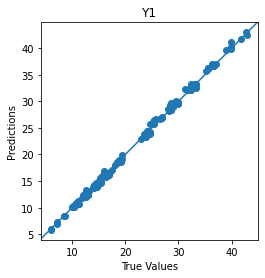

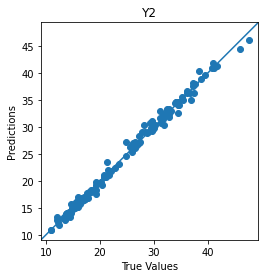

In [ ]:
plot_diff(test_Y[0], y_pred[0], title='Y1')
plot_diff(test_Y[1], y_pred[1], title='Y2')

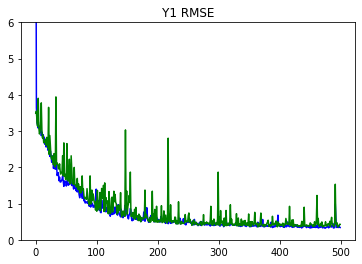

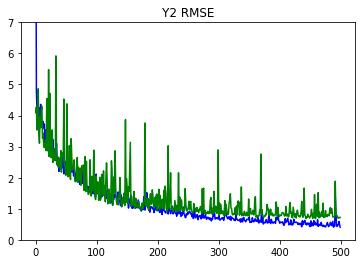

In [ ]:
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)